In [1]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 파일 불러오기

In [2]:
train = pd.read_csv("ml-100k/ua.base",
                    sep = "\t", names = ['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("ml-100k/ua.test",
                  sep = '\t', names = ['user', 'movie', 'rating', 'timestamp'])

In [3]:
train.head()

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
# pytorch tensor 데이터로 변환
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

# Latent Factor Model

In [5]:
rank = 150 # rank 값을 올리면 학습이 오래 걸리지만 정확도가 향상됨.
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [6]:
# 1번째 movie의 백터와 1번째 유저 값을 내적 --> 예상 점수
torch.sum(P[1] * Q[1])

tensor(16.2792, grad_fn=<SumBackward0>)

In [7]:
# 기본 Matrix Factorizatoin 구현
optimizer = torch.optim.Adam([P, Q], lr = 0.1)

X = []
Y = []
Y_test = []


for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1)
    cost = F.mse_loss(hypothesis ,ratings)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim = 1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        
        #epoch과 cost값을 X,Y에 저장함.
        X.append(epoch)
        Y.append(cost.item())
        
        Y_test.append(cost_test.item())
        
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 165.321640
epoch: 100, cost: 0.025527
epoch: 200, cost: 0.005227
epoch: 300, cost: 0.001517
epoch: 400, cost: 0.000482
epoch: 500, cost: 0.000177
epoch: 600, cost: 0.000106
epoch: 700, cost: 0.000059
epoch: 800, cost: 0.000074
epoch: 900, cost: 0.000074


In [8]:
#학습 후, 이전과 다르게 수용가능한 점수로 예측함.
torch.sum(P[1] * Q[1])

tensor(4.9978, grad_fn=<SumBackward0>)

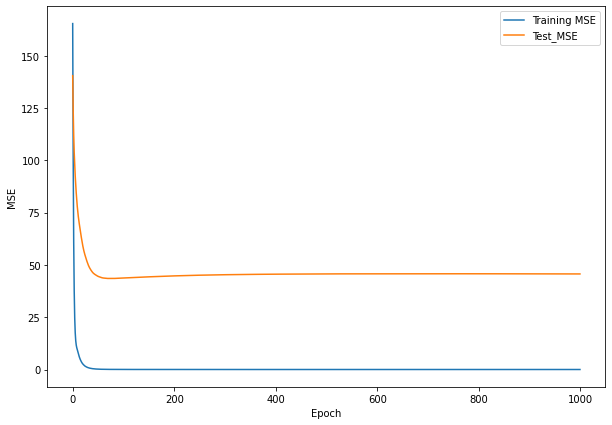

In [9]:
# Matplotlib으로 epoch 마다 Training MSE 그려보기
plt.figure(figsize = (10,7))
plt.ylabel("MSE")
plt.xlabel('Epoch')
plt.plot(X,Y, label = "Training MSE")
plt.plot(X,Y_test, label = "Test_MSE")
plt.legend()
plt.show()

# Regularization

In [5]:
rank = 120 # rank을 120으로 설정
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [6]:
#오버피팅 발생 --> regularization을 이용해 학습을 제한
optimizer = torch.optim.Adam([P, Q], lr = 0.1)

X = []
Y = []
Y_test = []

lambda1 = 0.0001
lambda2 = 0.0001


for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P**2)+ lambda2 * torch.sum(Q ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim = 1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        
        #epoch과 cost값을 X,Y에 저장함.
        X.append(epoch)
        Y.append(cost.item())
        
        Y_test.append(cost_test.item())
        
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 134.143860
epoch: 100, cost: 0.309425
epoch: 200, cost: 0.292895
epoch: 300, cost: 0.288709
epoch: 400, cost: 0.287187
epoch: 500, cost: 0.286638
epoch: 600, cost: 0.286408
epoch: 700, cost: 0.286290
epoch: 800, cost: 0.286218
epoch: 900, cost: 0.286168


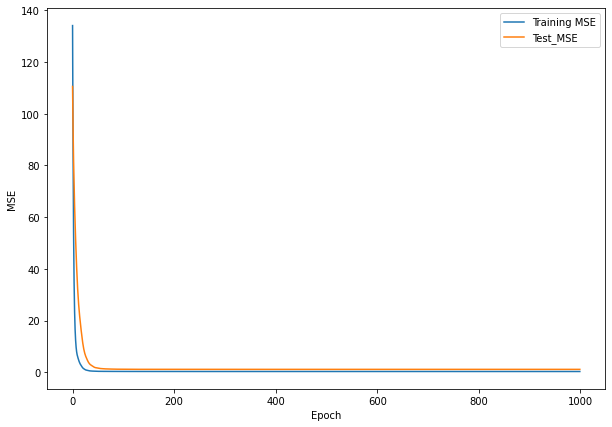

In [7]:
# Matplotlib으로 epoch 마다 Training MSE 그려보기
plt.figure(figsize = (10,7))
plt.ylabel("MSE")
plt.xlabel('Epoch')
plt.plot(X,Y, label = "Training MSE")
plt.plot(X,Y_test, label = "Test_MSE")
plt.legend()
plt.show()

# Bias

In [5]:
rank = 150 # rank을 100으로 설정
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [6]:
#Bias 추가하기
optimizer = torch.optim.Adam([P, Q], lr = 0.1)

X = []
Y = []
Y_test = []

#lambd값을 변경.
lambda1 = 0.1
lambda2 = 0.1
lambda3 = 0.1
lambda4 = 0.1

bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)
mean = (ratings.sum() / len(ratings)).item()


for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis ,ratings)
    # loss계산을 mean으로 실행 --> 학습이 별로
    loss = cost + lambda1 * torch.mean(P**2)+ lambda2 * torch.mean(Q ** 2)\
    + lambda3 * torch.mean(P  ** 2) + lambda4 * torch.mean(bias_user **2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim = 1)\
        + mean + bias_item[items_test] + bias_user[users_test]
        cost_test = F.mse_loss(hypo_test, ratings_test)
        
        #epoch과 cost값을 X,Y에 저장함.
        X.append(epoch)
        Y.append(cost.item())
        
        Y_test.append(cost_test.item())
        
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 154.201996
epoch: 100, cost: 0.021295
epoch: 200, cost: 0.003732
epoch: 300, cost: 0.000934
epoch: 400, cost: 0.000289
epoch: 500, cost: 0.000121
epoch: 600, cost: 0.000071
epoch: 700, cost: 0.000053
epoch: 800, cost: 0.000045
epoch: 900, cost: 0.000040


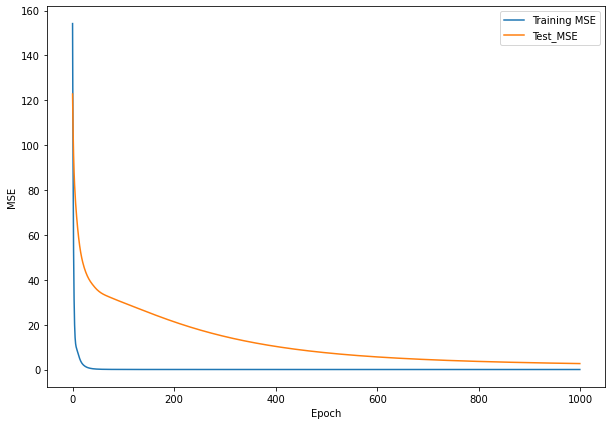

In [7]:
# Matplotlib으로 epoch 마다 Training MSE 그려보기
plt.figure(figsize = (10,7))
plt.ylabel("MSE")
plt.xlabel('Epoch')
plt.plot(X,Y, label = "Training MSE")
plt.plot(X,Y_test, label = "Test_MSE")
plt.legend()
plt.show()